In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2


In [2]:
from tensorflow.keras import mixed_precision
#activate 16 bit mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
#load Dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
assert X_train.shape == (50000, 32, 32, 3)
assert X_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [4]:
import numpy as np

print("y_train shape:", y_train.shape)
print("num classes:", len(np.unique(y_train)))
print("min/max label:", y_train.min(), y_train.max())

y_train shape: (50000, 1)
num classes: 100
min/max label: 0 99


In [5]:
# Convert NumPy arrays into a tf.data pipeline (yields (image, label) pairs)

ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [6]:
# Data augmentation
def data_augment(image,label):
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_hue(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

  return image, label

In [7]:
# Preprocessing
def preprocessing(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5)-1
  image = tf.image.resize(image, (224,224))

  return image , label

In [8]:
# prepare pipline
def prepare_pip(ds, augment=False, shuffle=False):
  ds = ds.shuffle(buffer_size=10000) if shuffle else ds
  ds = ds.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE) if augment else ds
  ds = ds.map(preprocessing, num_parallel_calls = tf.data.AUTOTUNE)
  ds = ds.batch(batch_size=64)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [9]:
# Preprocess the data
train_ds = prepare_pip(ds_train, augment=True, shuffle=True)
test_ds = prepare_pip(ds_test, augment=False, shuffle=False)

## Implement *VGG-13*

In [10]:
# regularization val
wd = 1e-4

#model vgg-16
model = Sequential([
    layers.Input(shape=(224,224,3)),

    layers.Conv2D(64,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(64,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(128,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(128,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(256,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(256,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(512,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(512,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(512,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Conv2D(512,(3,3), padding='same', activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),

    layers.Dense(4096, activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Dropout(0.5),

    layers.Dense(4096, activation="relu", kernel_initializer='he_normal', kernel_regularizer=l2(wd)),
    layers.Dropout(0.5),

    layers.Dense(100, activation="softmax", kernel_initializer='he_normal', kernel_regularizer=l2(wd))

])

#compile
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       409,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,360,548 (493.47 MB)

 Trainable params: 129,360,548 (493.47 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# callbacks
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, restore_best_weights=True
)
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 511s 398ms/step - accuracy: 0.0335 - loss: 6.6994 - val_accuracy: 0.1412 - val_loss: 5.2613 - learning_rate: 1.0000e-04
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 300ms/step - accuracy: 0.1455 - loss: 5.1826 - val_accuracy: 0.2649 - val_loss: 4.3649 - learning_rate: 1.0000e-04
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 300ms/step - accuracy: 0.2589 - loss: 4.3528 - val_accuracy: 0.3793 - val_loss: 3.7251 - learning_rate: 1.0000e-04
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 301ms/step - accuracy: 0.3604 - loss: 3.7283 - val_accuracy: 0.4535 - val_loss: 3.2980 - learning_rate: 1.0000e-04
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 300ms/step - accuracy: 0.4548 - loss: 3.2575 - val_accuracy: 0.4873 - val_loss: 3.1308 - learning_rate: 1.0000e-04
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 235s 300ms/step - accuracy: 0.5321 - loss: 2.9171 - val_accuracy: 0.5186 - val_loss: 2.9948 - learning_rate: 1.0000e-04
Epoch 7/100
782/782 ━━━━━━━━━━━━━━

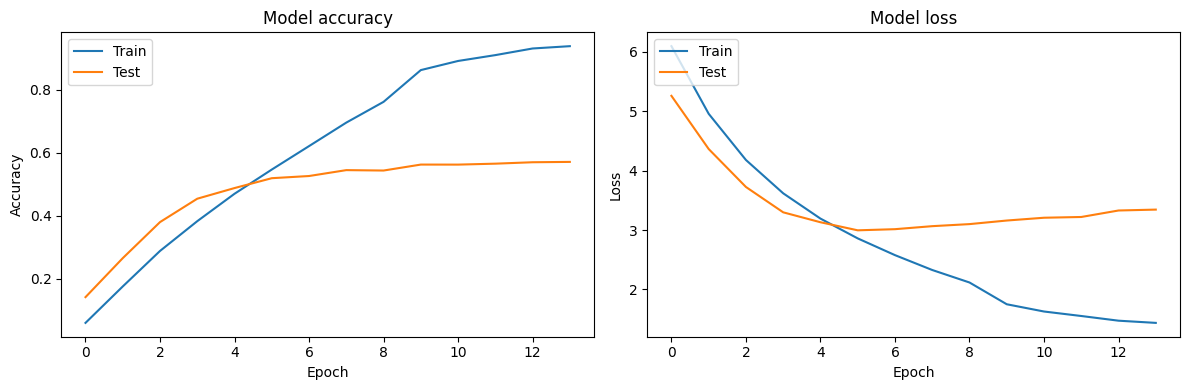

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()